In [75]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

from utils_plotting import plot_with_power_law, val_display_dict, val_map, display_dict

In [76]:
df = pd.read_csv("data/sweep.csv")
df_big = pd.read_csv("data/extrapolation.csv")

opt_params_df = pd.read_csv("data/opt_params_data.csv")
opt_params_df = opt_params_df[opt_params_df["kaplan"] == True] # only use the kaplan-style curve fits

fit_entropy = False


In [77]:
datasets = list(df["data"].unique())
datasets = sorted(datasets)
vals = [c for c in df.columns if "CrossEntropyLoss" in c and "eval" in c]

In [78]:
def get_drop_df(df, data):
    drop_df = df[df["data"] == data].copy()
    return drop_df

def power_law_with_constant(x, a, b, c, d):
    xc = np.maximum(x - c, 0)
    return b * np.power(xc, a) + d

In [79]:
df[df["data"] == "fineweb-100b"]['iso_flop'].sum()

np.float64(1.0329463089308721e+21)

In [80]:
df_big["iso_flop"]

0    1.000000e+21
1    1.000000e+21
2    1.000000e+21
3    1.000000e+21
4    1.000000e+21
5    1.000000e+21
Name: iso_flop, dtype: float64

# Train-to-train

In [81]:
def plot_loss_diff_f(ax, df, data_1, data_2, color="blue", 
                     key_1="val_loss", key_2="val_loss",
                    downstream=False, params=None, iso_flop=None, extrapolate=False,
                    add_x=None, 
                    fit_ey=False):

    drop_df1 = get_drop_df(df, data_1)
    drop_df2 = get_drop_df(df, data_2)

    join_df = drop_df1.join(drop_df2.set_index("tokens"), how="inner", on="tokens", rsuffix="_1")

    if iso_flop is not None:
        join_df = join_df[join_df["iso_flop"] == iso_flop]
    if params is not None:
        join_df = join_df[join_df["params"] == params]

    x = join_df[key_1]
    y = join_df[f"{key_2}_1"]
    
    ex = opt_params_df[(opt_params_df["data"] == data_1) & (opt_params_df["loss_name"] == key_1)]["E"].values[0]

    ey = opt_params_df[(opt_params_df["data"] == data_2) & (opt_params_df["loss_name"] == key_2)]["E"].values[0]

    if fit_ey:
        results_df = plot_with_power_law(ax, x, y, color, display_dict[data_2], add_x=add_x, ex=ex, ey=None)
    else:
        results_df = plot_with_power_law(ax, x, y, color, display_dict[data_2], add_x=add_x, ex=ex, ey=ey)

    return results_df

In [122]:
def plot_single_train(ax, data, key="val_loss", lims=False, params=None, iso_flop=None, extrapolate=False, add_x=None):
    
    out_params = []
    r_squareds = []
    errors = []
    for j, d in enumerate(datasets):
        big_loss = df_big[df_big["data"] == data][key].values[0]
        results = plot_loss_diff_f(ax,
                                   df, 
                                data_1=data,
                                data_2=d,
                                color=sns.color_palette()[j], 
                                downstream=False,
                                params=params,
                                iso_flop=iso_flop,
                                extrapolate=extrapolate,
                                add_x=big_loss - 1, 
                                fit_ey=fit_entropy)
        
        pred_loss = power_law_with_constant(big_loss, *results["params"].values[0])
        val_loss = df_big[df_big["data"] == d][key].values[0]
        ax.scatter([big_loss], [val_loss], color=sns.color_palette()[j], marker="*", s=30, zorder=10, edgecolor="black", linewidth=0.2)
        out_params.append(results["params"].values[0])
        r_squareds.append(results["r_squared"])
        errors.append(pred_loss - val_loss)
    
    if lims:
        ax.set_ylim(0.8, 4)
    ax.set_xlabel("Loss 0 (Trained on data 0)")
    ax.set_ylabel("Loss 1 (Trained on data 1)")

    ax.set_title(f"Data 0: {display_dict[data]}")

    return out_params, r_squareds, errors

def plot_train_curves(lims=False):
    sns.set_palette("Set2", len(datasets))
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(2, 3, figsize=(8, 5))
    fig.subplots_adjust(wspace=0.4)
    fig.subplots_adjust(hspace=0.5)
    
    all_params = []
    all_errors = []

    for i, data in enumerate(datasets):
        ax = axs[i // 3, i % 3]

        params, _, errors = plot_single_train(ax, data, lims=lims)
        all_params.append(params)
        all_errors.append(errors)

        if i == len(datasets) - 1:
            ax.legend(loc='upper center', bbox_to_anchor=(1.6, 1.5), ncol=1, title="Data 1")
    
    return all_params, all_errors

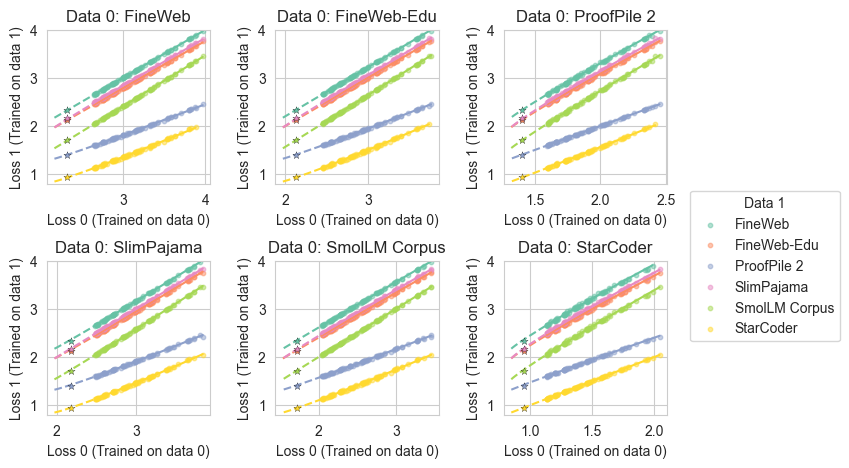

In [123]:
params, errors = plot_train_curves(lims=True)

plt.savefig("figures/train_transfer.pdf", bbox_inches="tight")

plt.show()

In [124]:
print(f"Data 0 & Data 1 & $\kappa$ & $K$ \\\\")
for i, d1 in enumerate(datasets):
    for j, d2 in enumerate(datasets):
        if i == j:
            continue
        print(f"{display_dict[d1]} & {display_dict[d2]} & {params[i][j][0]} & {params[i][j][1]} \\\\")

Data 0 & Data 1 & $\kappa$ & $K$ \\
FineWeb & FineWeb-Edu & 0.9993672129008692 & 0.985766439160985 \\
FineWeb & ProofPile 2 & 1.0653537897873724 & 0.5960987286755511 \\
FineWeb & SlimPajama & 0.9658398246551085 & 1.0395299734434793 \\
FineWeb & SmolLM Corpus & 1.005012474421091 & 1.054815004525007 \\
FineWeb & StarCoder & 1.0904140724708045 & 0.6230307900469053 \\
FineWeb-Edu & FineWeb & 1.0004689037149535 & 1.0144310832890906 \\
FineWeb-Edu & ProofPile 2 & 1.0662580144036193 & 0.6048866683525692 \\
FineWeb-Edu & SlimPajama & 0.9697772093091833 & 1.0540015787682846 \\
FineWeb-Edu & SmolLM Corpus & 1.0062157661890683 & 1.0702320070783213 \\
FineWeb-Edu & StarCoder & 1.10023685087841 & 0.6331016233093456 \\
ProofPile 2 & FineWeb & 0.9372916317326982 & 1.6238017629395856 \\
ProofPile 2 & FineWeb-Edu & 0.9365819990706228 & 1.6011247543766798 \\
ProofPile 2 & SlimPajama & 0.9067853679290657 & 1.6622161259189963 \\
ProofPile 2 & SmolLM Corpus & 0.9442389200815708 & 1.7193826535335652 \\
Proo

# Test to test

In [107]:
def plot_test_test(ax, data, key):
    out_params = []
    for d in datasets:
        # if d == data:
        #     continue
        j = datasets.index(d)
        big_loss = df_big[df_big["data"] == data][key].values[0]
        results = plot_loss_diff_f(ax,
                            df, 
                            data_1=data,
                            data_2=d,
                            key_1= key,
                            key_2= key,
                            color=sns.color_palette()[j], 
                            downstream=False,
                            params=None,
                            add_x=big_loss - 1, 
                            fit_ey=False)
        out_params.append(results["params"].values[0])
        # pred_loss = power_law_with_constant(big_loss, *results["params"].values[0])
        val_loss = df_big[df_big["data"] == d][key].values[0]
        ax.scatter([big_loss], [val_loss], color=sns.color_palette()[j], marker="*", s=30, zorder=10, edgecolor="black", linewidth=0.2)

    return out_params

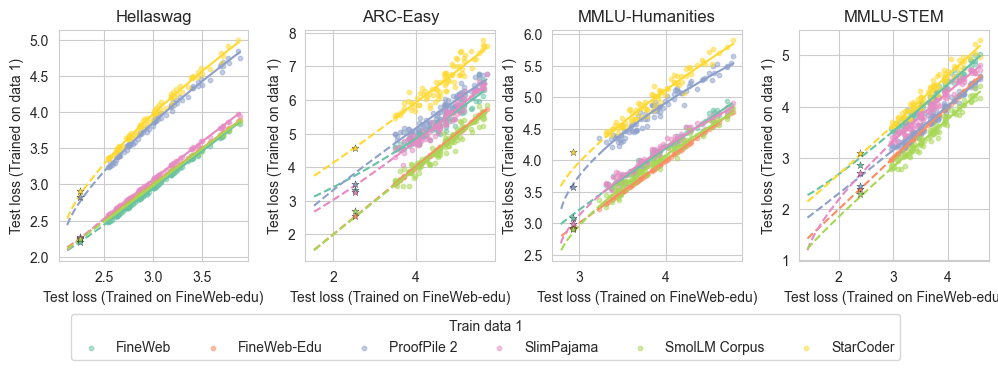

In [125]:
data = "fineweb-edu-100b"

keys = [
        "eval/downstream_ce_loss/hellaswag_test_ce_loss",
        "eval/downstream_ce_loss/arc_easy_test_ce_loss",
        "eval/downstream_ce_loss/mmlu_humanities_test_ce_loss",
        "eval/downstream_ce_loss/mmlu_stem_test_ce_loss"
        ]

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
fig.subplots_adjust(wspace=0.3)

for i, key in enumerate(keys):
    plot_test_test(axs[i], data, key)
    axs[i].set_title(val_display_dict[key])
    axs[i].set_xlabel("Test loss (Trained on FineWeb-edu)")
    axs[i].set_ylabel("Test loss (Trained on data 1)")
    
axs[0].legend(loc='upper center', bbox_to_anchor=(2.25, -0.2), ncol=6, title=f"Train data 1")
plt.savefig("figures/test_to_test_down.pdf", bbox_inches="tight")
plt.show()

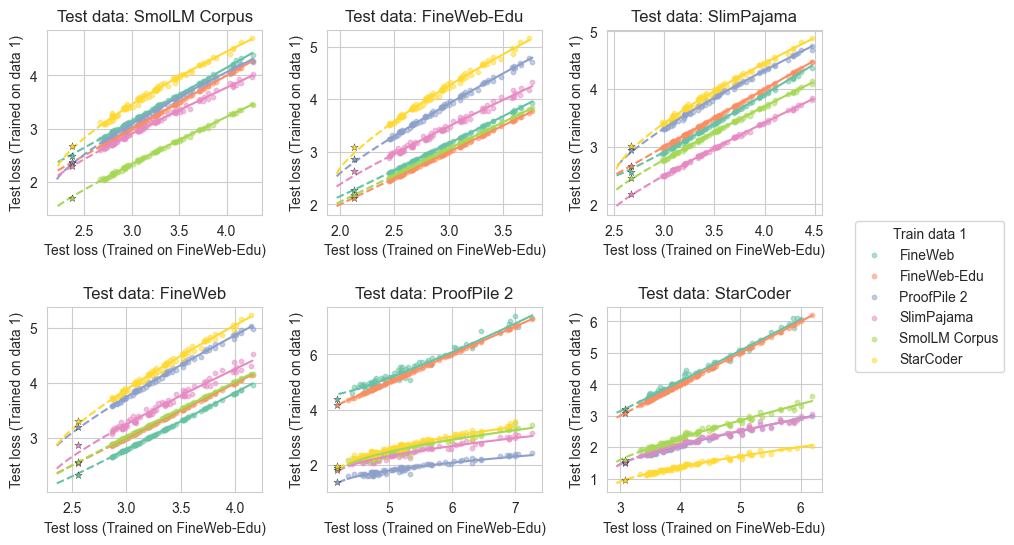

In [131]:
data = "fineweb-edu-100b"

keys = list(val_map.values())

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.5)

for i, key in enumerate(keys):
    ax = axs[i // 3, i % 3]
    plot_test_test(ax, data, key)
    ax.set_title(f"Test data: {val_display_dict[key]}")
    ax.set_xlabel(f"Test loss (Trained on {display_dict[data]})")
    ax.set_ylabel("Test loss (Trained on data 1)")
    
ax.legend(loc='upper center', bbox_to_anchor=(1.5, 1.5), ncol=1, title=f"Train data 1")
plt.savefig("figures/test_to_test_pre.pdf", bbox_inches="tight")
plt.show()


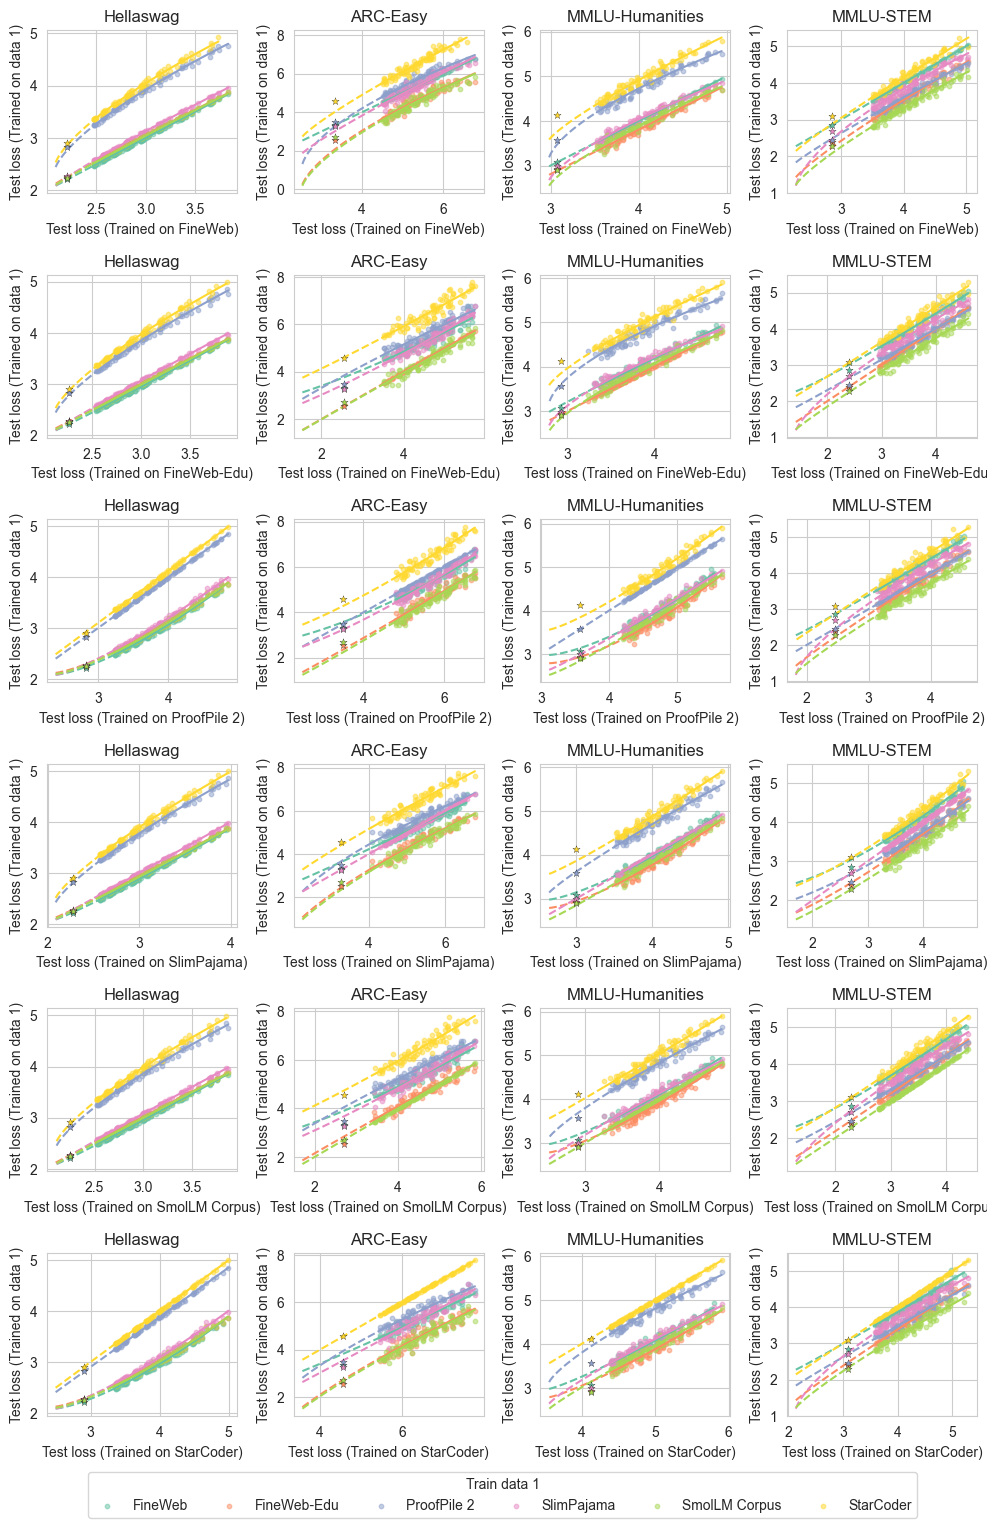

In [129]:
data = "fineweb-edu-100b"

keys = [
        "eval/downstream_ce_loss/hellaswag_test_ce_loss",
        "eval/downstream_ce_loss/arc_easy_test_ce_loss",
        "eval/downstream_ce_loss/mmlu_humanities_test_ce_loss",
        "eval/downstream_ce_loss/mmlu_stem_test_ce_loss"
        ]

fig, axs = plt.subplots(6, 4, figsize=(12, 18))
fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.5)

for j, data in enumerate(datasets):
    for i, key in enumerate(keys):
        ax = axs[j, i]
        plot_test_test(ax, data, key)
        ax.set_title(val_display_dict[key])
        ax.set_xlabel(f"Test loss (Trained on {display_dict[data]})")
        ax.set_ylabel("Test loss (Trained on data 1)")
    
ax.legend(loc='upper center', bbox_to_anchor=(-1.5, -0.3), ncol=6, title=f"Train data 1")
plt.savefig("figures/test_to_test_down_all1.pdf", bbox_inches="tight")
plt.show()

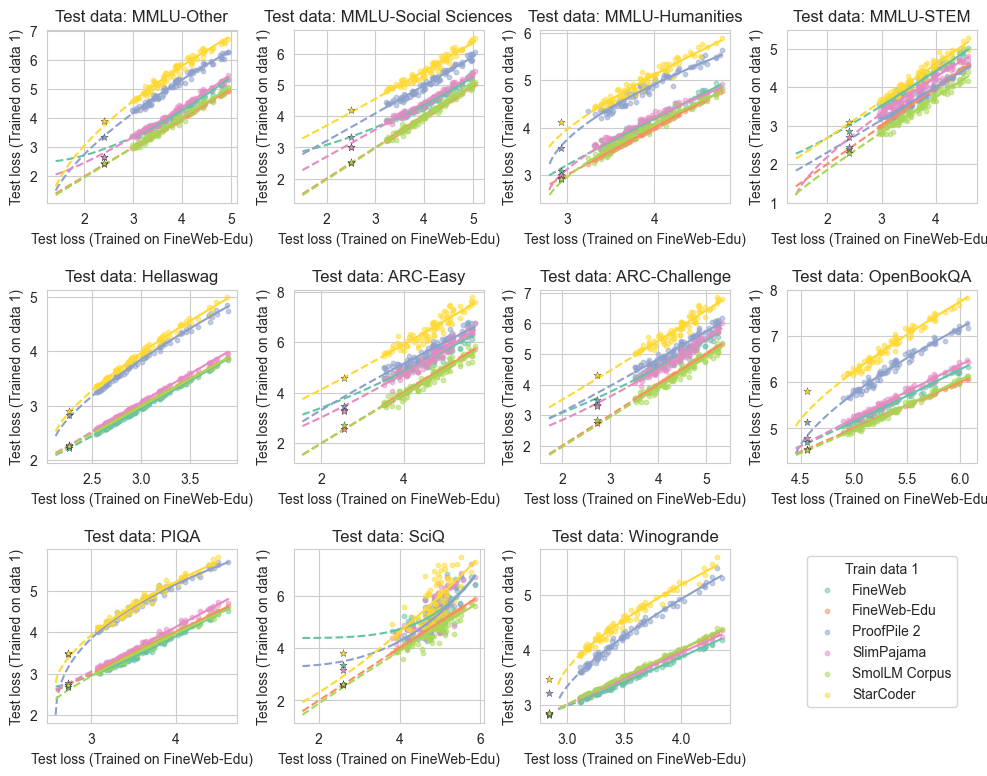

In [128]:
keys = [
    'eval/downstream_ce_loss/mmlu_other_test_ce_loss',
                    'eval/downstream_ce_loss/mmlu_social_sciences_test_ce_loss',
                    'eval/downstream_ce_loss/mmlu_humanities_test_ce_loss',
                    'eval/downstream_ce_loss/mmlu_stem_test_ce_loss',
                    'eval/downstream_ce_loss/hellaswag_test_ce_loss',
                    'eval/downstream_ce_loss/arc_easy_test_ce_loss',
                    'eval/downstream_ce_loss/arc_challenge_test_ce_loss',
                    'eval/downstream_ce_loss/openbook_qa_test_ce_loss',
                    'eval/downstream_ce_loss/piqa_test_ce_loss',
                    'eval/downstream_ce_loss/sciq_test_ce_loss',
                    'eval/downstream_ce_loss/winogrande_test_ce_loss'
                    ]

data = "fineweb-edu-100b"

fig, axs = plt.subplots(3, 4, figsize=(12, 9))
fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.5)

for i, key in enumerate(keys):
    ax = axs[i // 4, i % 4]
    plot_test_test(ax, data, key)
    ax.set_title(f"Test data: {val_display_dict[key]}")
    ax.set_xlabel(f"Test loss (Trained on {display_dict[data]})")
    ax.set_ylabel("Test loss (Trained on data 1)")
    
# Remove last panel and put legend there
fig.delaxes(axs[2, 3])
ax.legend(loc='upper center', bbox_to_anchor=(1.8, 1), ncol=1, title=f"Train data 1")
plt.savefig("figures/test_to_test_down_all2.pdf", bbox_inches="tight")
plt.show()


# Train-to-test

In [90]:
def plot_loss_same_f(ax, df, data, color="blue", test_key="olmo_suite_ce_loss", label=None, add_x=None, fit_ey=False):
    loss_key = "val_loss" # "train/CrossEntropyLoss"

    drop_df = get_drop_df(df, data)
    x = drop_df[loss_key]
    y = drop_df[test_key]

    if label is None:
        label = data

    ex = opt_params_df[(opt_params_df["data"] == data) & (opt_params_df["loss_name"] == "val_loss")]["E"].values[0]

    ey = opt_params_df[(opt_params_df["data"] == data) & (opt_params_df["loss_name"] == test_key)]["E"].values[0]

    if fit_ey:
        coeffs = plot_with_power_law(ax, x, y, color, label, add_x=add_x, ex=ex, ey=None)
    else:
        coeffs = plot_with_power_law(ax, x, y, color, label, add_x=add_x, ex=ex, ey=ey)

    return coeffs

In [91]:
def plot_test_loss(ax, key, opt_model=False, group_by_train=False, values=datasets, ylim=None):

    drop_df = df.copy()

    if opt_model: # find min loss for each iso_flop for each dataset keeping all columns
        drop_df['min_value_in_group'] = drop_df.groupby(["data", "iso_flop"])["val_loss"].transform('min')
        drop_df = drop_df[drop_df['val_loss'] == drop_df['min_value_in_group']]


    params_df = pd.DataFrame()

    if group_by_train:
        for j, k in enumerate(values):
            if k in val_display_dict:
                label = val_display_dict[k]
            else: 
                label = k.replace("eval/downstream_ce_loss/", "").replace("_ce_loss", "").replace("_test", "")
                label = label.replace("eval/", "").replace("_val/CrossEntropyLoss", " ").replace("_", " ").title()
            
            big_loss = df_big[df_big["data"] == key]["val_loss"].values[0]
            params = plot_loss_same_f(ax, drop_df, 
                                    data=key, 
                                    color=sns.color_palette()[j], 
                                    test_key=k,
                                    label=label,
                                    add_x=big_loss-1,
                                    fit_ey=fit_entropy)
            ax.scatter([big_loss], [df_big[df_big["data"] == key][k].values[0]], color=sns.color_palette()[j], marker="*", s=30, zorder=10, edgecolor="black", linewidth=0.2)
            param_dict = {"a": params["params"].values[0][0],
                                        "b": params["params"].values[0][1],
                                        "c": params["params"].values[0][2],
                                        "d": params["params"].values[0][3],
                                        "train": key,
                                        "test": k}
            params_df = pd.concat([params_df, pd.DataFrame(param_dict, index=[0])])

        ax.set_title(f"Train: {display_dict[key]}")
    else:
        for j, d in enumerate(values):
            big_loss = df_big[df_big["data"] == d]["val_loss"].values[0]
            params = plot_loss_same_f(ax, drop_df, 
                                    data=d, 
                                    color=sns.color_palette()[j], 
                                    test_key=key,
                                    label=display_dict[d],
                                    add_x=big_loss-1)
            ax.scatter([big_loss], [df_big[df_big["data"] == d][key].values[0]], color=sns.color_palette()[j], marker="*", s=30, zorder=10, edgecolor="black", linewidth=0.2)
            param_dict = {"a": params["params"].values[0][0],
                                        "b": params["params"].values[0][1],
                                        "c": params["params"].values[0][2],
                                        "d": params["params"].values[0][3],
                                        "train": d,
                                        "test": key}
            params_df = pd.concat([params_df, pd.DataFrame(param_dict, index=[0])])

        if key in val_display_dict:
            title = val_display_dict[key]
        else: 
            title = key.replace("eval/downstream_ce_loss/", "").replace("_ce_loss", "").replace("_test", "")
            title = title.replace("eval/", "").replace("_val/CrossEntropyLoss", " ").replace("_", " ").title()
        
        ax.set_title(f"Test: {title}")

    ax.set_xlabel("Train Loss")
    ax.set_ylabel("Test Loss")
    if ylim is not None:
        ax.set_ylim(ylim)
    return params_df 

def plot_all_test_loss(loss_list, opt_model=False, group_by_train=False, colors="Set2", ylim=None):
    if len(loss_list) == 6 or group_by_train:
        fig, axs = plt.subplots(2, 3, figsize=(8, 5))
        cols = 3
    elif len(loss_list) == 16:
        fig, axs = plt.subplots(4, 4, figsize=(16, 16))
        cols = 4
    elif len(loss_list) == 12 or len(loss_list) == 11:
        fig, axs = plt.subplots(3, 4, figsize=(16, 12))
        cols = 4
    elif len(loss_list) == 2:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        cols = 2
    else:
        raise ValueError("Only 6 or 16 test losses")
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.5)
    if colors == "Set1":
        sat = 0.5
    else:
        sat = 1
    sns.set_palette(colors, len(datasets) if not group_by_train else len(loss_list), desat=sat)
    sns.set_style("whitegrid")

    params_df = pd.DataFrame()
    if group_by_train:
        for i, key in enumerate(datasets):
            if cols == 2:
                ax = axs[i]
            else:
                ax = axs[i // cols, i % cols]
            pdf = plot_test_loss(ax, key, opt_model, group_by_train=True, values=loss_list, ylim=ylim)
            params_df = pd.concat([params_df, pdf])
    else:
        for i, key in enumerate(loss_list):
            if cols == 2:
                ax = axs[i]
            else:
                ax = axs[i // cols, i % cols]
            pdf = plot_test_loss(ax, key, opt_model, ylim=ylim)
            params_df = pd.concat([params_df, pdf])
        
    title = "Train data" if not group_by_train else "Test data"
    if i == 10:
        # Blank out last axis
        ax = axs[-1, -1]
        ax.axis("off")
        ax = axs[-1, -2]
        ax.legend(loc='upper center', bbox_to_anchor=(1.7, 0.7), ncol=1, title=title)
    elif i == 5:
        ax.legend(loc='upper center', bbox_to_anchor=(1.6, 1.5), ncol=1, title=title)
    elif i == 1:
        ax.legend(loc='upper center', bbox_to_anchor=(1.35, 0.7), ncol=1, title=title)
    else:
        ax.legend(loc='upper center', bbox_to_anchor=(-(cols/2) + 0.5, -0.2), ncol=6, title=title)
    
    return params_df

def plot_single_test_loss(key, opt_model=False):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    sns.set_palette("Set2", len(datasets))
    sns.set_style("whitegrid")

    slopes, intercepts = plot_test_loss(ax, key, opt_model)
    print(slopes)
    print(intercepts)

    ax.legend(loc='upper center', bbox_to_anchor=(1.35, 0.75), ncol=1, title=f"Train data")

6
['eval/fineweb_100b_val/CrossEntropyLoss', 'eval/fineweb_edu_100b_val/CrossEntropyLoss', 'eval/proof_pile_2_val/CrossEntropyLoss', 'eval/slimpajama_val/CrossEntropyLoss', 'eval/smollm_val/CrossEntropyLoss', 'eval/starcoder_val/CrossEntropyLoss']


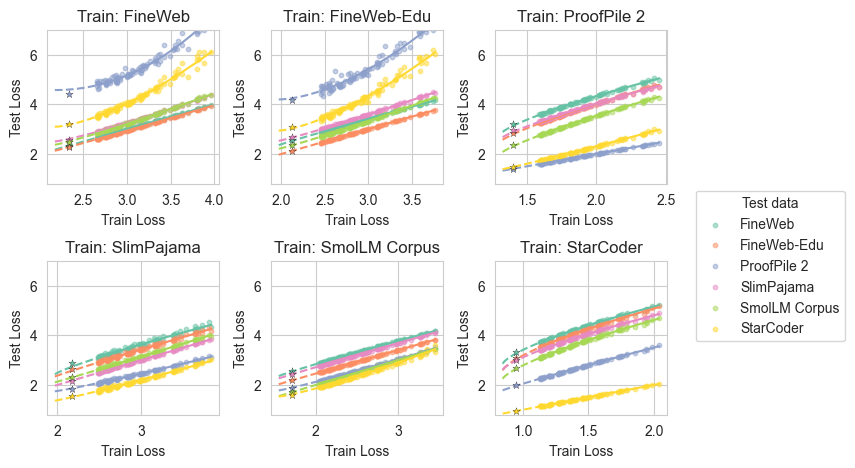

In [92]:
val_losses = [c for c in df.columns if "CrossEntropyLoss" in c and "eval" in c and "c4" not in c and "1T" not in c]
val_losses = sorted(val_losses)
print(len(val_losses))
print(val_losses)
all_params = plot_all_test_loss(val_losses, opt_model=False, group_by_train=True, ylim=(0.8, 7))

plt.savefig("figures/train_function_transfer.pdf", bbox_inches="tight")

plt.show()

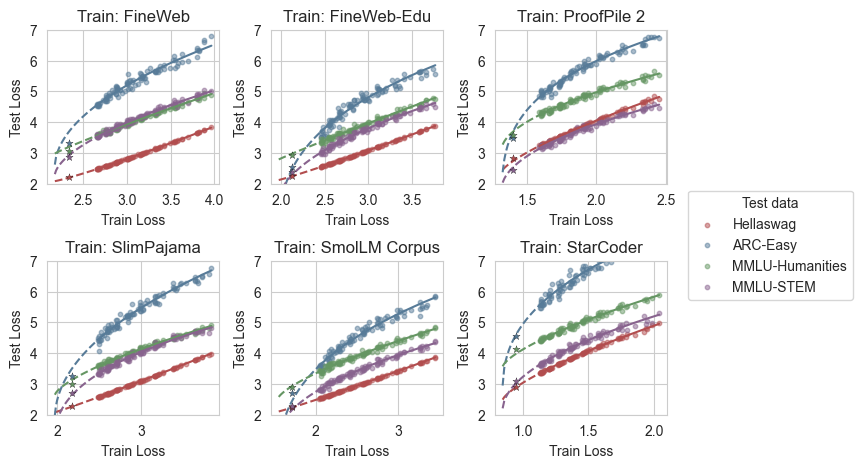

In [93]:
plot_all_test_loss([
                    "eval/downstream_ce_loss/hellaswag_test_ce_loss",
                    "eval/downstream_ce_loss/arc_easy_test_ce_loss",
                    "eval/downstream_ce_loss/mmlu_humanities_test_ce_loss",
                    "eval/downstream_ce_loss/mmlu_stem_test_ce_loss"
                    ],
                    group_by_train=True, colors="Set1", ylim=(2, 7))

plt.savefig("figures/test_transfer.pdf", bbox_inches="tight")

plt.show()

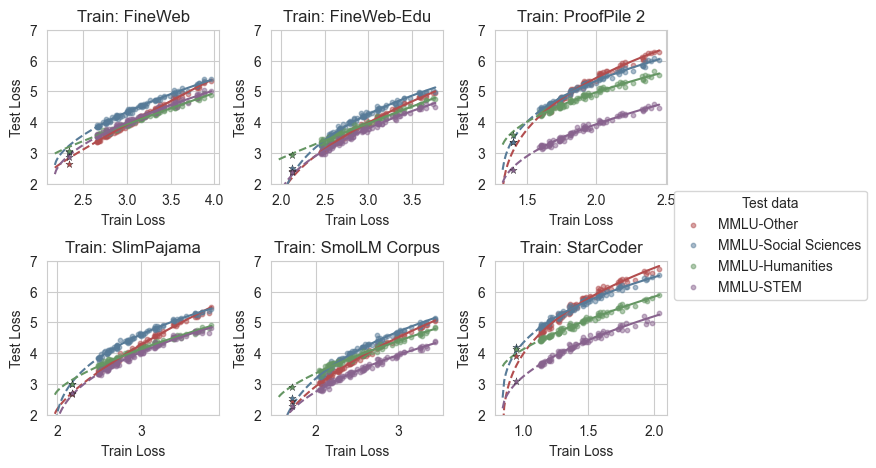

In [94]:
plot_all_test_loss([
                    'eval/downstream_ce_loss/mmlu_other_test_ce_loss',
                    'eval/downstream_ce_loss/mmlu_social_sciences_test_ce_loss',
                    'eval/downstream_ce_loss/mmlu_humanities_test_ce_loss',
                    'eval/downstream_ce_loss/mmlu_stem_test_ce_loss'
                    ],
                    group_by_train=True, colors="Set1", ylim=(2, 7))

plt.savefig("figures/test_transfer_mmlu.pdf", bbox_inches="tight")

plt.show()

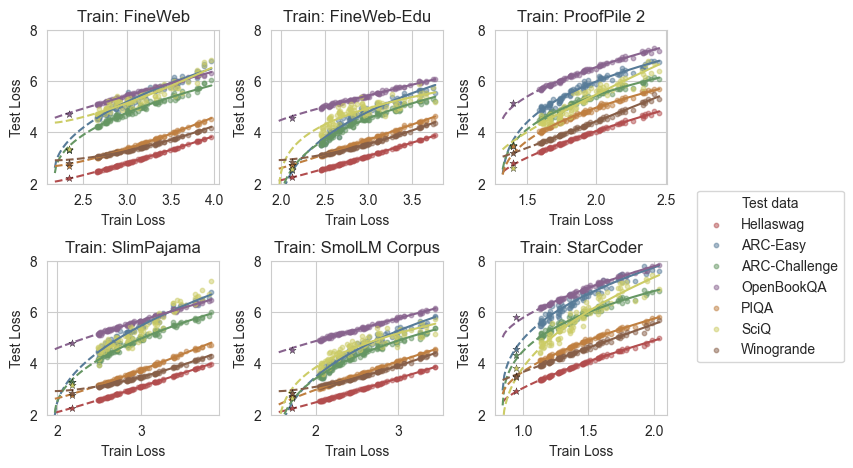

In [95]:
plot_all_test_loss([
                     'eval/downstream_ce_loss/hellaswag_test_ce_loss',
                    'eval/downstream_ce_loss/arc_easy_test_ce_loss',
                    'eval/downstream_ce_loss/arc_challenge_test_ce_loss',
                    'eval/downstream_ce_loss/openbook_qa_test_ce_loss',
                    'eval/downstream_ce_loss/piqa_test_ce_loss',
                    'eval/downstream_ce_loss/sciq_test_ce_loss',
                    'eval/downstream_ce_loss/winogrande_test_ce_loss'
                    ],
                    group_by_train=True, colors="Set1", ylim=(2, 8))

plt.savefig("figures/test_transfer_olmo.pdf", bbox_inches="tight")

plt.show()

# Figure 1

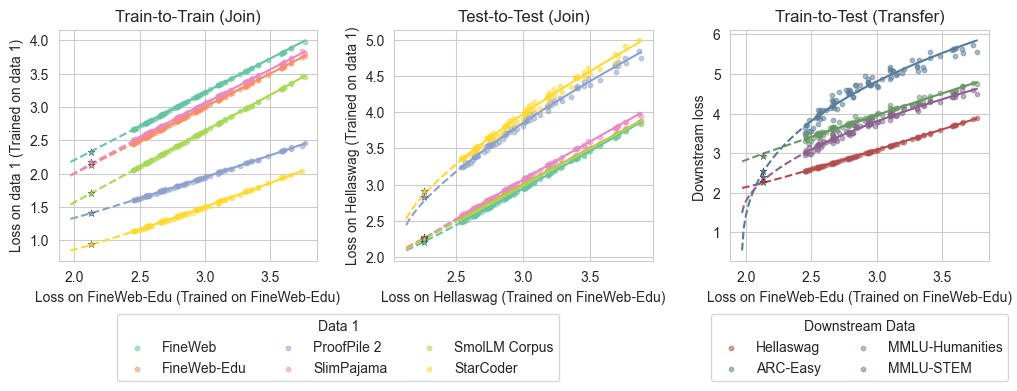

In [119]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
fig.subplots_adjust(wspace=0.3)
sns.set_palette("Set2", len(datasets))
sns.set_style("whitegrid")

data = "fineweb-edu-100b"

ax = axs[0]

params0, r_squared, _ = plot_single_train(ax, data=data, lims=False, extrapolate=False)
ax.set_xlabel(f"Loss on {display_dict[data]} (Trained on {display_dict[data]})")
ax.set_ylabel(f"Loss on data 1 (Trained on data 1)")
ax.set_title("Train-to-Train (Join)")

ax.legend(loc="lower left", bbox_to_anchor=(0.2, -0.55),  title="Data 1", ncols=3)

ax = axs[1]

# params1 = plot_test_loss(ax, data, opt_model=False, group_by_train=True, values=val_losses)
# ax.set_xlabel(f"Train Loss 0: {display_dict[data]}")
# ax.set_title("Train-to-Test (Transfer)")
params1 = plot_test_test(ax, data, "eval/downstream_ce_loss/hellaswag_test_ce_loss")
ax.set_xlabel(f"Loss on Hellaswag (Trained on {display_dict[data]})")
ax.set_ylabel("Loss on Hellaswag (Trained on data 1)")
ax.set_title("Test-to-Test (Join)")

ax = axs[2]

sns.set_palette("Set1", 4, desat=0.5)

params2 = plot_test_loss(ax, data, group_by_train=True, 
                        values=[
                                "eval/downstream_ce_loss/hellaswag_test_ce_loss",
                                "eval/downstream_ce_loss/arc_easy_test_ce_loss",
                                "eval/downstream_ce_loss/mmlu_humanities_test_ce_loss",
                                "eval/downstream_ce_loss/mmlu_stem_test_ce_loss"
                                ])

ax.legend(loc="lower left", bbox_to_anchor=(-0.1, -0.55),  title="Downstream Data", ncols=2)
ax.set_xlabel(f"Loss on {display_dict[data]} (Trained on {display_dict[data]})")
ax.set_ylabel(f"Downstream loss ") # (Trained on {display_dict[data]})
ax.set_title("Train-to-Test (Transfer)")

plt.savefig("figures/fig_1.pdf", bbox_inches="tight")

plt.show()

In [97]:
print(f"Data 0 & Data 1 & $\kappa$ & $K$ & $E_0$ & $E_1$ \\\\\\midrule")
for i, d1 in enumerate(datasets):
    print(f"FineWeb-Edu & {display_dict[d1]} & {params0[i][0]:.2f} & {params0[i][1]:.2f} & {params0[i][2]:.2f} & {params0[i][3]:.2f} \\\\")

Data 0 & Data 1 & $\kappa$ & $K$ & $E_0$ & $E_1$ \\\midrule
FineWeb-Edu & FineWeb & 1.00 & 1.01 & 1.97 & 2.17 \\
FineWeb-Edu & FineWeb-Edu & 1.00 & 1.00 & 1.97 & 1.97 \\
FineWeb-Edu & ProofPile 2 & 1.07 & 0.60 & 1.97 & 1.32 \\
FineWeb-Edu & SlimPajama & 0.97 & 1.05 & 1.97 & 1.97 \\
FineWeb-Edu & SmolLM Corpus & 1.01 & 1.07 & 1.97 & 1.53 \\
FineWeb-Edu & StarCoder & 1.10 & 0.63 & 1.97 & 0.85 \\


In [135]:
print(f"Train data 0 & Train data 1 & $\kappa$ & $K$ & $E_{{2|0}}$ & $E_{{2|1}}$ \\\\\\midrule")
for i, d1 in enumerate(datasets):
    row = params1[i]
    print(f"FineWeb-Edu & {display_dict[d1]} & {row[0]:.2f} & {row[1]:.2f} & {row[2]:.2f} & {row[3]:.2f} \\\\")

Train data 0 & Train data 1 & $\kappa$ & $K$ & $E_{2|0}$ & $E_{2|1}$ \\\midrule
FineWeb-Edu & FineWeb & 1.05 & 0.98 & 2.12 & 2.08 \\
FineWeb-Edu & FineWeb-Edu & 1.00 & 1.00 & 2.12 & 2.12 \\
FineWeb-Edu & ProofPile 2 & 0.74 & 1.60 & 2.12 & 2.39 \\
FineWeb-Edu & SlimPajama & 0.95 & 1.11 & 2.12 & 2.08 \\
FineWeb-Edu & SmolLM Corpus & 0.99 & 1.01 & 2.12 & 2.10 \\
FineWeb-Edu & StarCoder & 0.74 & 1.64 & 2.12 & 2.48 \\


In [136]:
tests = [
        "eval/downstream_ce_loss/hellaswag_test_ce_loss",
        "eval/downstream_ce_loss/arc_easy_test_ce_loss",
        "eval/downstream_ce_loss/mmlu_humanities_test_ce_loss",
        "eval/downstream_ce_loss/mmlu_stem_test_ce_loss"
        ]
print(f"Train data & Test data & $\kappa$ & $K$ & $E_0$ & $E_{{1|0}}$ \\\\\\midrule")
for i, d1 in enumerate(tests):
    row = params2[params2["test"] == d1]
    row = row.iloc[0]
    print(f"FineWeb-Edu & {val_display_dict[d1]} & {row['a']:.2f} & {row['b']:.2f} & {row['c']:.2f} & {row['d']:.2f} \\\\")

Train data & Test data & $\kappa$ & $K$ & $E_0$ & $E_{1|0}$ \\\midrule
FineWeb-Edu & Hellaswag & 1.08 & 0.93 & 1.97 & 2.12 \\
FineWeb-Edu & ARC-Easy & 0.36 & 4.68 & 1.97 & 0.07 \\
FineWeb-Edu & MMLU-Humanities & 0.96 & 1.14 & 1.97 & 2.79 \\
FineWeb-Edu & MMLU-STEM & 0.53 & 2.35 & 1.97 & 1.41 \\
